# Analyse des données NHANES (Étude Diabète, Âge, IMC)

## Introduction
Ce notebook présente une analyse des données du **National Health and Nutrition Examination Survey (NHANES)**, cycle 2017-2018 (J).

L'objectif est d'explorer les relations entre :
- **L'Indice de Masse Corporelle (IMC)**
- **L'Âge**
- **Le Statut Diabétique**


## 1. Installation et Chargement des Bibliothèques
Nous augmentons le délai de téléchargement pour éviter les échecs de connexion et installons les dépendances critiques comme `stringi`.

In [6]:
# Augmenter le temps de téléchargement (évite les timeouts)
options(timeout = 300)

# Liste des packages nécessaires
packages <- c("haven", "dplyr", "janitor", "ggplot2", "stringi")

# Installation des packages manquants
new_packages <- packages[!(packages %in% installed.packages()[,"Package"])]
if(length(new_packages)) install.packages(new_packages, dependencies = TRUE)

# Chargement
library(haven)
library(dplyr)
#library(janitor)
library(ggplot2)

## 2. Chargement des données NHANES
Chargement des modules Démographie, Anthropométrie, Questionnaire Diabète et Glycémie.

In [5]:
demo <- read_xpt("Data/DEMO_J.xpt")
bmx  <- read_xpt("Data/BMX_J.xpt")  
diq  <- read_xpt("Data/DIQ_J.xpt")  
glu  <- read_xpt("Data/GLU_J.xpt")  

## 3. Fusion et Inspection
Fusion des modules NHANES à l’aide de l’identifiant `seqn`. Nous utilisons des noms en minuscules suite au nettoyage précédent.

In [11]:
df <- demo %>%
  left_join(bmx, by = "SEQN") %>%
  left_join(diq, by = "SEQN") %>%
  left_join(glu, by = "SEQN")

# Dimensions après fusion
dim(df)

# Vérifier l'absence de doublons
anyDuplicated(df$SEQN)

# Aperçu des valeurs manquantes pour les variables clés
colSums(is.na(df[, c("RIDAGEYR", "RIAGENDR", "BMXBMI", "DIQ010", "LBXGLU")]
))

[1] 9254  122

[1] 0

RIDAGEYR RIAGENDR   BMXBMI   DIQ010   LBXGLU 
       0        0     1249      357     6363

## 4. Nettoyage et Recodage
Simplification des noms et création de variables binaires pour le modèle.

In [14]:
df_clean <- df %>%
  select(
    SEQN,
    age = RIDAGEYR,
    sex = RIAGENDR,
    bmi = BMXBMI,
    diabetes = DIQ010,
    glucose = LBXGLU
  ) %>%
  mutate(
    diabetes_bin = case_when(
      diabetes == 1 ~ 1,
      diabetes == 2 ~ 0,
      TRUE ~ NA_real_
    ),
    sex = case_when(
      sex == 1 ~ "Male",
      sex == 2 ~ "Female",
      TRUE ~ NA_character_
    )
  )

head(df_clean)


SEQN,age,sex,bmi,diabetes,glucose,diabetes_bin
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
93703,2,Female,17.5,2,NA,0
93704,2,Male,15.7,2,NA,0
93705,66,Female,31.7,2,NA,0
93706,18,Male,21.5,2,NA,0
93707,13,Male,18.1,2,NA,0
93708,66,Female,23.7,3,122,NA


## 5. Analyses Descriptives
Résumé statistique de l'âge, de l'IMC et du nombre de cas de diabète.

In [15]:
# Résumé statistique de l'âge
summary(df_clean$age)

# Résumé statistique de l'IMC
summary(df_clean$bmi)

# Répartition du diabète (binaire)
table(df_clean$diabetes_bin)
prop.table(table(df_clean$diabetes_bin))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   11.00   31.00   34.33   58.00   80.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  12.30   20.40   25.80   26.58   31.30   86.20    1249 


   0    1 
7816  893 


        0         1 
0.8974624 0.1025376 

## 6. Visualisations
Impact de l'IMC sur le statut diabétique.

Warning message:
"Removed 1249 rows containing non-finite outside the scale range (`stat_bin()`)."


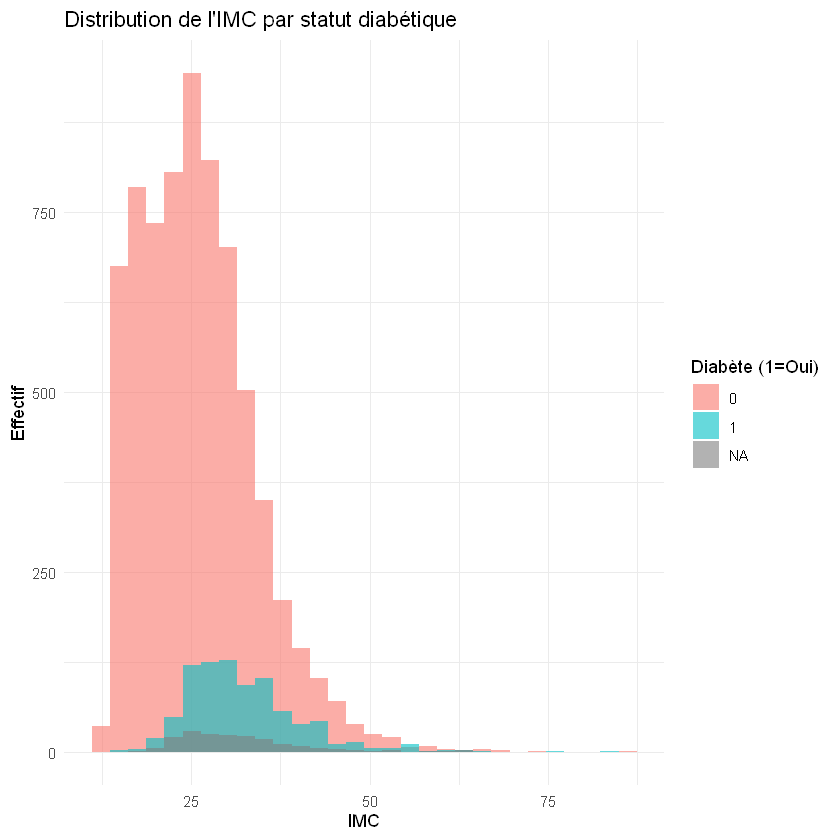

In [16]:
ggplot(df_clean, aes(x = bmi, fill = factor(diabetes_bin))) +
  geom_histogram(alpha = 0.6, bins = 30, position = "identity") +
  labs(
    title = "Distribution de l'IMC par statut diabétique",
    x = "IMC",
    y = "Effectif",
    fill = "Diabète (1=Oui)"
  ) +
  theme_minimal()

## 7. Modélisation (Régression Logistique)
Calcul des Odds Ratios pour quantifier les risques.

In [18]:
df_model <- df_clean %>%
  mutate(
    sex = factor(sex, levels = c("Female", "Male"))
  ) %>%
  filter(
    !is.na(age),
    !is.na(bmi),
    !is.na(diabetes_bin)
  )


Afin de réaliser la régression logistique, un sous-ensemble de données a été constitué.
Le sexe a été recodé en variable catégorielle avec les femmes comme catégorie de référence.
Les observations présentant des valeurs manquantes pour l’âge, l’IMC ou le statut diabétique ont été exclues afin d’assurer la validité de l’estimation du modèle.
Le jeu de données final (df_model) contient uniquement les individus disposant d’informations complètes sur l’ensemble des variables d’intérêt.

In [19]:
nrow(df_model)


[1] 7828

Après nettoyage, le modèle est estimé sur X individus disposant de toutes les informations nécessaires.

In [20]:

modele <- glm(
  diabetes_bin ~ age + bmi + sex,
  data = df_model,
  family = binomial(link = "logit")
)

summary(modele)



Call:
glm(formula = diabetes_bin ~ age + bmi + sex, family = binomial(link = "logit"), 
    data = df_model)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.591869   0.250550 -30.301  < 2e-16 ***
age          0.062190   0.002490  24.977  < 2e-16 ***
bmi          0.071856   0.005273  13.628  < 2e-16 ***
sexMale      0.397005   0.082525   4.811  1.5e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5302.3  on 7827  degrees of freedom
Residual deviance: 3944.8  on 7824  degrees of freedom
AIC: 3952.8

Number of Fisher Scoring iterations: 7


La régression logistique met en évidence une association indépendante et statistiquement significative entre l’âge, l’indice de masse corporelle (IMC) et le sexe avec le diabète déclaré.
L’augmentation de l’âge et de l’IMC est associée à une hausse progressive du risque de diabète, traduisant l’effet cumulé du vieillissement et de la surcharge pondérale sur le métabolisme glucidique.
Par ailleurs, à âge et IMC comparables, le sexe masculin présente un risque plus élevé de diabète que le sexe féminin, suggérant une vulnérabilité supplémentaire liée à des facteurs biologiques ou comportementaux.
Dans l’ensemble, ces résultats sont cohérents avec les connaissances épidémiologiques actuelles sur le diabète de type 2 et confirment le caractère multifactoriel de cette pathologie.

Calculer les Odds Ratios

In [ ]:
OR <- exp(coef(modele))
IC <- exp(confint(modele))

resultats <- data.frame(
  Variable = names(OR),
  OR = round(OR, 2),
  IC_inf = round(IC[,1], 2),
  IC_sup = round(IC[,2], 2)
)

knitr::kable(resultats, caption = "Odds Ratios ajustés (IC 95 %)")


Les coefficients du modèle logistique ont été transformés en Odds Ratios afin de faciliter l’interprétation clinique.

L’âge et l’IMC sont significativement associés au diabète déclaré.
Chaque année supplémentaire augmente la probabilité de diabète, indépendamment de l’IMC et du sexe.
De même, une augmentation de l’IMC est associée à une hausse marquée du risque de diabète, confirmant le rôle central de la surcharge pondérale.
À âge et IMC équivalents, le sexe masculin présente un risque plus élevé de diabète que le sexe féminin.

In [21]:
AIC(modele)


[1] 3952.755

Le critère AIC permet d’évaluer la qualité globale du modèle et servira de référence pour de futures comparaisons.